#  Проект 4. Компьютер говорит «Нет»

#### воскресим в памяти знания о банковском скоринге :


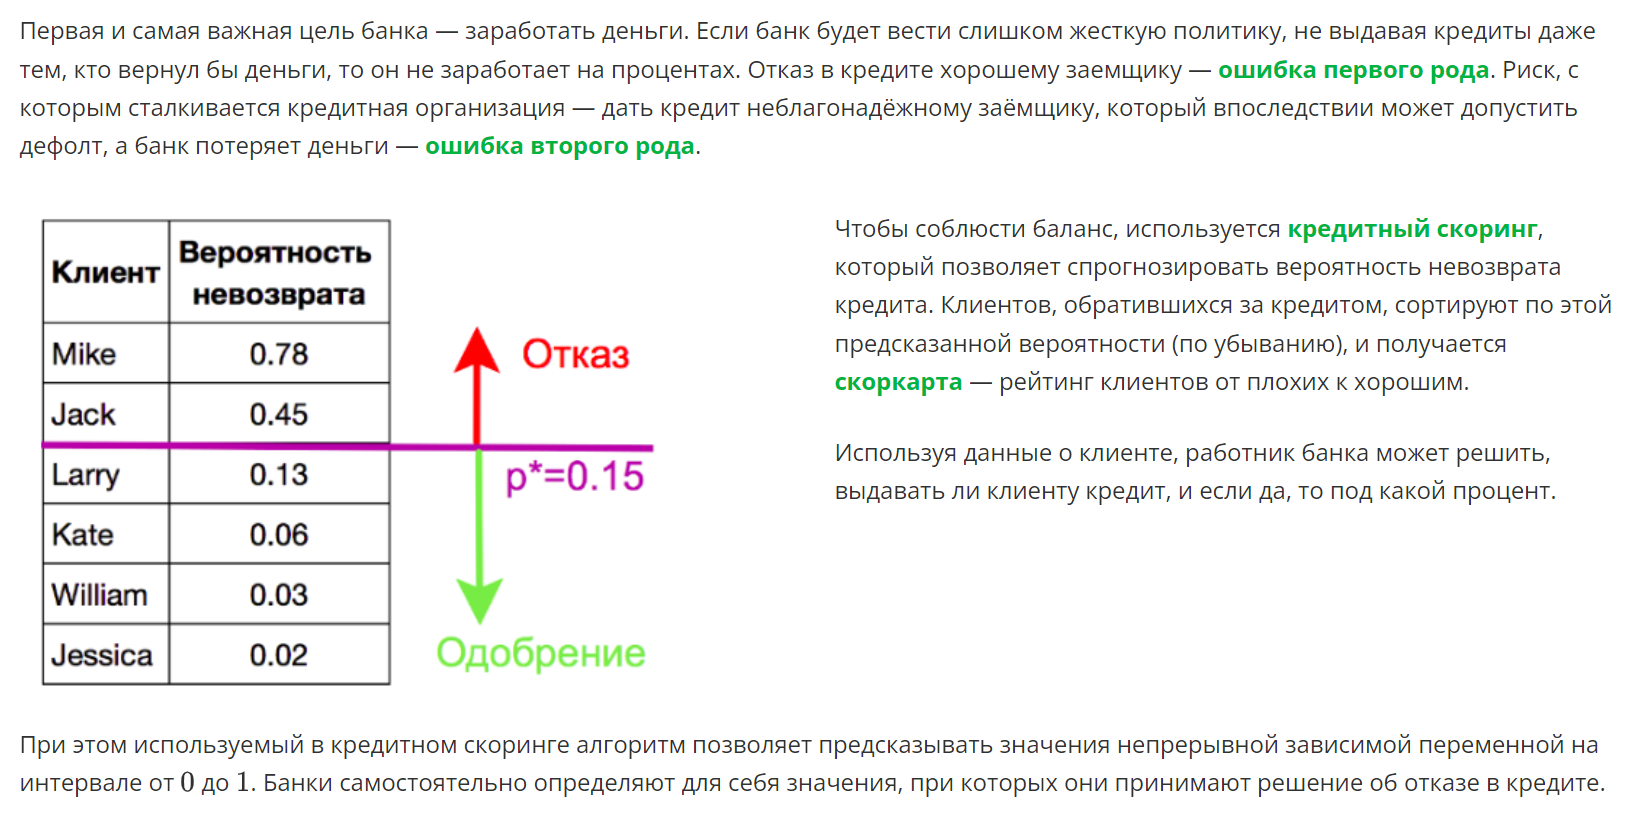

В построении моделей банковского скоринга используется модель логистической регрессии


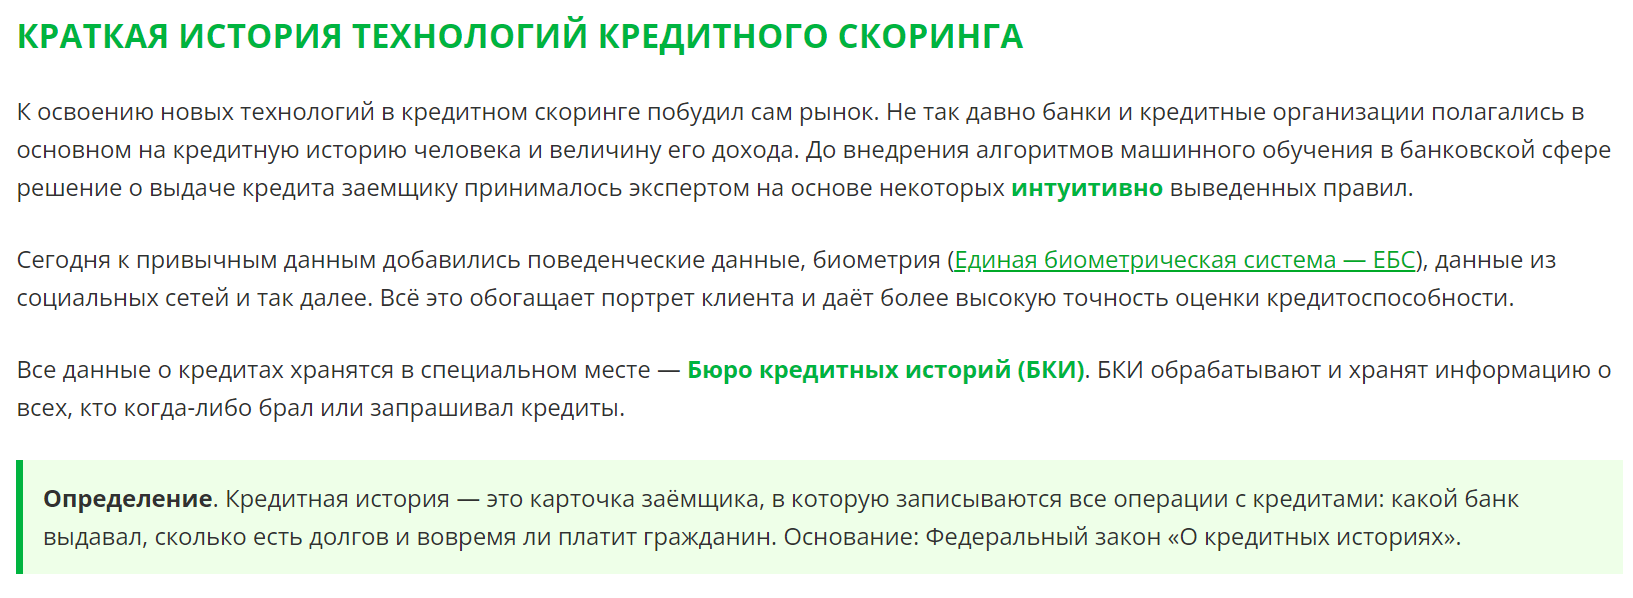

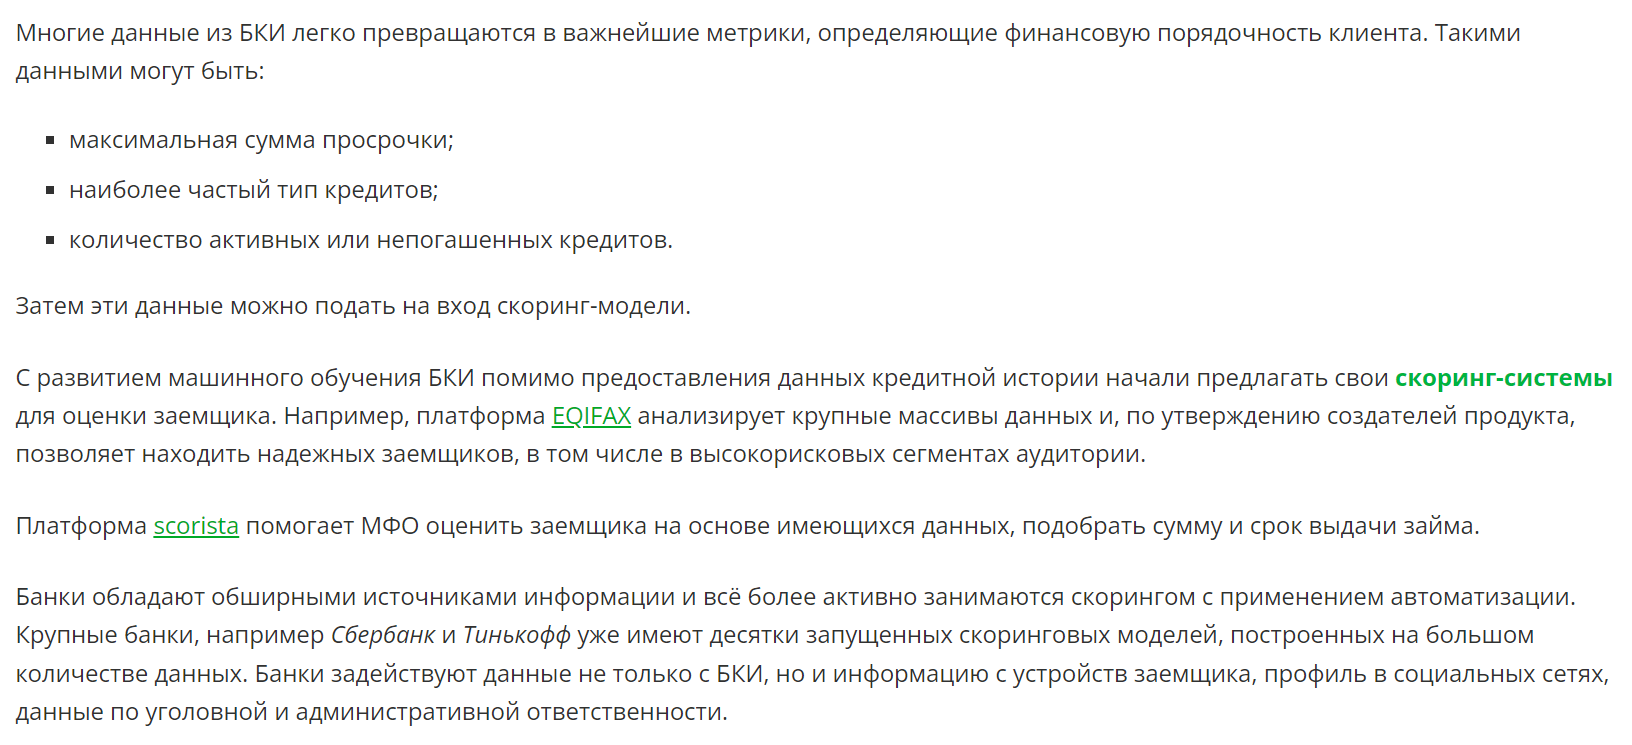

#### кредитный скориинг

Кредитный скоринг используется для оценки заемщиков, которые уже брали кредиты (повторных клиентов).

Для первичных клиентов обычно подразумевается создание отдельной скоринговой модели. Первичная модель больше опирается на анкетные данные, а риск для банка при этом увеличивается. 

	ВОТ ПОЧЕМУ ЛЮДЯМ С ДЛИННОЙ КРЕДИТНОЙ ИСТОРИЕЙ (КИ) НАМНОГО ОХОТНЕЕ ВЫДАЮТ КРЕДИТЫ, ЧЕМ КЛИЕНТАМ, КОТОРЫЕ НИКОГДА НЕ БРАЛИ КРЕДИТЫ!

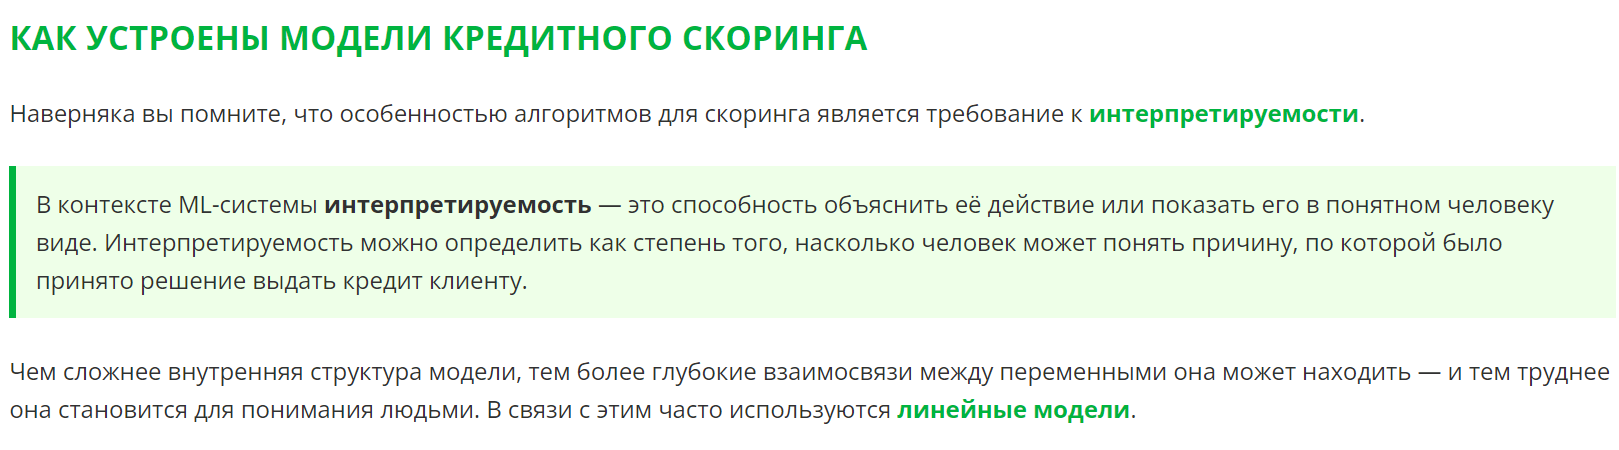

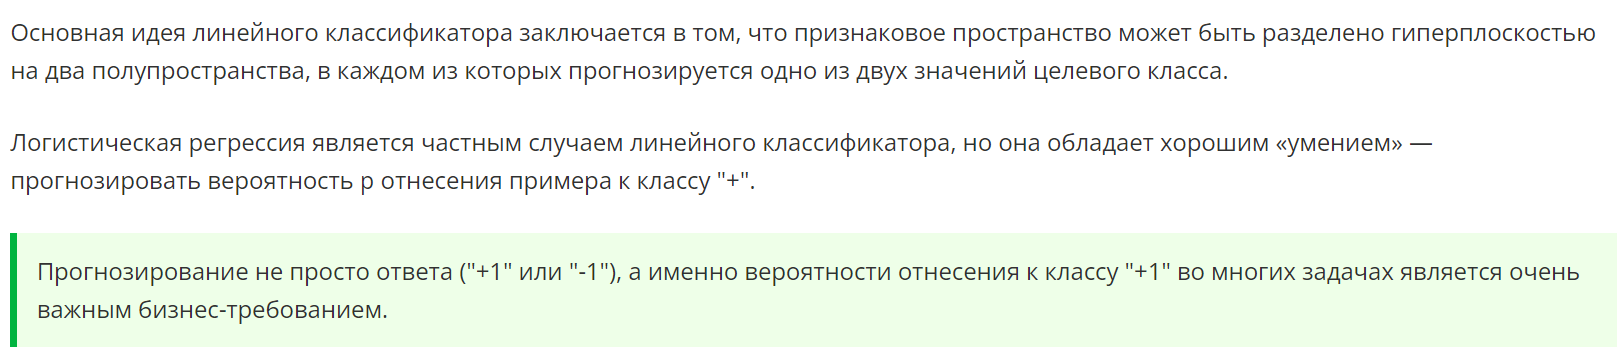

### ▶***Моя задача – построить модель кредитного скоринга для вторичных клиентов. Хм... Для этого надо будет разобраться с работой алгоритмов и определить значимые параметры заемщика.***

---


In [1960]:
# подключаем необходимые библиотеки
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import auc, roc_auc_score, roc_curve, mean_squared_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import sklearn.metrics as metrics

import warnings 
warnings.filterwarnings('ignore')



In [1961]:
# зафиксируем RANDOM_SEED, версию пакетов, общую текущую дату
RANDOM_SEED = 42
!pip freeze > requirements.txt
CURRENT_DATE = pd.to_datetime('17/03/2022')

In [1962]:
# путь к файлу, доступ через google colab
from google.colab import drive
drive.mount('/content/drive')
path = './drive/My Drive/Colab Notebooks/skillfactory/module_4/проект4'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1963]:
# загружаем датасет
train_df = pd.read_csv(path+'/train.csv')

In [1964]:
train_df.head(3)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0


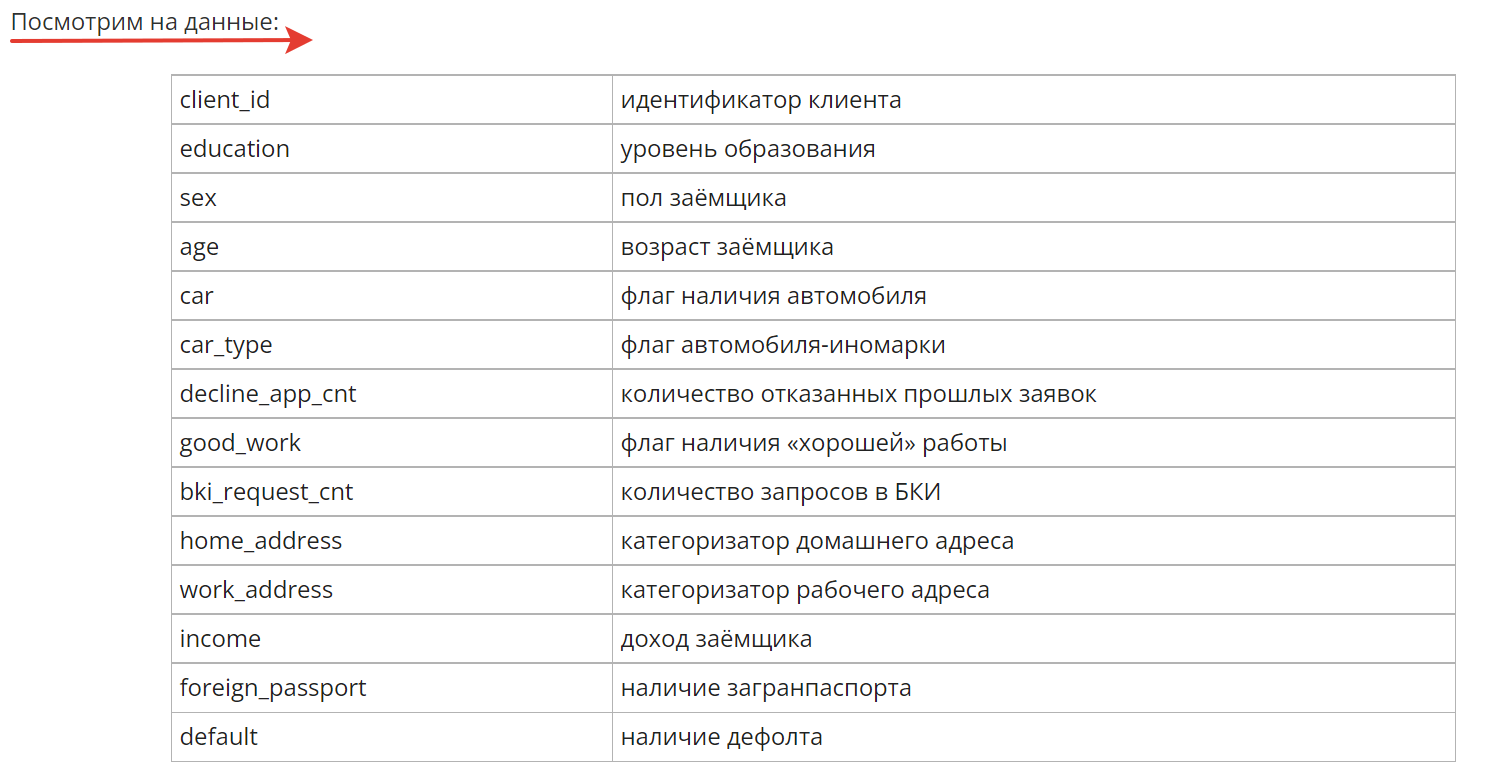

* sna - связь заемщика с клиентами банка

* first_time - давность наличия информации о заемщике

* score_bki - скоринговый балл по данным из БКИ

* region_rating - рейтинг региона

* app_date - дата подачи заявки

In [1965]:
print('Размерность тестового датасета: ', train_df.shape)

Размерность тестового датасета:  (73799, 19)


In [1966]:
# загрузим тестовые данные 
test_df = pd.read_csv(path+'/test.csv')

In [1967]:
test_df.head(3)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y


In [1968]:
print('Размерность тестового датасета: ', test_df.shape)

Размерность тестового датасета:  (36349, 18)


In [1969]:
from pandas.io.formats.info import DataFrameInfo
# Для обработки признаков объединяем трейн и тест в один датасет

train_df['sample'] = 1   # помечаем где у нас трейн
test_df['sample'] = 0    # помечаем где у нас тест
test_df['default'] = -1  # в тесте у нас нет значения default, мы его должны предсказать, 
                         # но его значения 0 или 1, поэтому заполняем его временно -1 для избежания ошибки

df = test_df.append(train_df, sort=False).reset_index(drop=True)   # объединяем

## посмотрим информация по объедененному датасету

In [1970]:
# посмотрим на размеры датасета
df.shape

(110148, 20)

In [1971]:
# посмотрим информацию 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

In [1972]:
# количество пропущенных значений
df.isnull().sum()

client_id             0
app_date              0
education           478
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
sample                0
default               0
dtype: int64

**Датасет содержит:**

* В тренировочной выборке 73799 клиентов, в тестовой выборке 36349.Всего имеются данные о 110148 клиентах.

* 20 признаков:  1 - временной ряд, 7 бинарных (в т.ч. добавленный признак sample), 6 категориальных и 6 числовых.

* Всего пропусков 478 (307 - в наборе train, 171 - в наборе test), все пропуски в переменной education.

* **Целевая переменная default является бинарной (True - False).**


Text(0.5, 1.0, 'Диаграма целевого признака default в датасете, %')

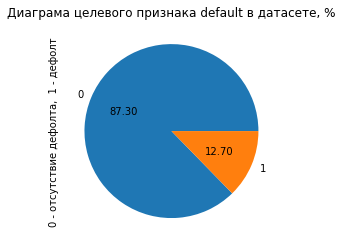

In [1973]:
# посмотрим на распределение целевого признака default в тренеровочном датасете
train_df['default'].value_counts().plot(kind='pie', label='0 - отсутствие дефолта,  1 - дефолт', autopct="%.2f")

plt.title('Диаграма целевого признака default в датасете, %')

## функции

In [1974]:
# Определение наличия выбросов в отдельном признаке датасета.
# Определение границ выбросов.Подсчёт общего количества выбросов в признаке.

def vybros(df_col):
        
    q1 = df[df_col].quantile(0.25)
    q3 = df[df_col].quantile(0.75)
    IQR = q3 - q1
    low = q1 - (1.5 * IQR)
    high = q3 + (1.5 * IQR)
    for i in df[df_col]:
        if (i <= low) or (i >= high):
            print("В признаке '{}' есть значения, которые могут считаться выбросами".format(df_col))
            break
        
    print("Количество выбросов в признаке '{}': {}."
          .format(df_col, ((df[df_col] < (q1 - 1.5 * IQR)) | (df[df_col] > (q3 + 1.5 * IQR))).sum()))
    print("25-й процентиль: {}, 75-й процентиль: {}, IQR: {}, Границы выбросов: [{}, {}]".format(q1, q3, IQR, low, high))

##проведем предобработку данных

Для того чтобы понять какие действия нам необходимо предпринять, мы начнём с анализа данных  поймём как из них можно извлечь побольше информации. 

In [1975]:
# Найдем количество уникальных значений в столбцах (строковых признаках) датасета
object_columns = [c for c in df.columns if df[c].dtypes == 'object']
for column in object_columns:
    unique = df[column].unique()
    print('Количество уникальных значений для столбца',column, '-', len(unique), unique)

Количество уникальных значений для столбца app_date - 120 ['22MAR2014' '24JAN2014' '23MAR2014' '03FEB2014' '04FEB2014' '17APR2014'
 '02FEB2014' '28MAR2014' '23JAN2014' '24APR2014' '25FEB2014' '15JAN2014'
 '13APR2014' '12MAR2014' '17MAR2014' '01FEB2014' '15FEB2014' '01APR2014'
 '20FEB2014' '20APR2014' '27JAN2014' '24FEB2014' '18JAN2014' '16JAN2014'
 '13FEB2014' '02APR2014' '07MAR2014' '08APR2014' '21FEB2014' '16MAR2014'
 '08JAN2014' '24MAR2014' '19MAR2014' '19JAN2014' '18APR2014' '05APR2014'
 '25MAR2014' '06MAR2014' '29APR2014' '28APR2014' '22JAN2014' '27MAR2014'
 '31JAN2014' '11JAN2014' '22FEB2014' '05FEB2014' '07APR2014' '14MAR2014'
 '06APR2014' '02MAR2014' '06JAN2014' '05MAR2014' '10MAR2014' '22APR2014'
 '26FEB2014' '16FEB2014' '01MAR2014' '04JAN2014' '30JAN2014' '09FEB2014'
 '11FEB2014' '04MAR2014' '29JAN2014' '04APR2014' '25APR2014' '19FEB2014'
 '14FEB2014' '26MAR2014' '13JAN2014' '18MAR2014' '06FEB2014' '03MAR2014'
 '23APR2014' '18FEB2014' '20JAN2014' '23FEB2014' '31MAR2014' '08FE

In [1976]:
# Найдем количество уникальных значений в столбцах  датасета
int64_columns = [c for c in train_df.columns if (train_df[c].dtypes == 'int64') ]
for column in int64_columns:
    unique = train_df[column].unique()
    if column!='income':       # доход клиента здесь весь перечислять не нужно!
       print('Количество уникальных значений для столбца',column, '-', len(unique), unique)
    elif column =='income':    # укажу только количество уникальных значений.
      print('Количество уникальных значений для столбца',column, '-', len(unique))

Количество уникальных значений для столбца client_id - 73799 [ 25905  63161  25887 ... 103695    861  15796]
Количество уникальных значений для столбца age - 52 [62 59 25 53 48 27 39 50 54 29 32 30 23 37 36 41 28 58 26 45 44 43 56 40
 34 33 67 38 46 42 35 24 61 21 52 55 49 57 31 64 63 51 22 65 47 66 68 60
 69 70 72 71]
Количество уникальных значений для столбца decline_app_cnt - 21 [ 0  2  1  3  4  6  5  7  8  9 13 11 19 10 22 33 14 12 15 24 16]
Количество уникальных значений для столбца good_work - 2 [0 1]
Количество уникальных значений для столбца bki_request_cnt - 38 [ 1  3  2  0  4  7  5  8  6 13 10 22 12 11 34  9 16 14 26 21 18 24 15 19
 32 17 20 23 27 36 53 25 45 33 28 41 29 46]
Количество уникальных значений для столбца region_rating - 7 [50 80 60 40 70 20 30]
Количество уникальных значений для столбца home_address - 3 [1 2 3]
Количество уникальных значений для столбца work_address - 3 [2 3 1]
Количество уникальных значений для столбца income - 966
Количество уникальных значений

In [1977]:
# Найдем количество уникальных значений в столбцах  датасета
float64_columns = [c for c in df.columns if df[c].dtypes == 'float64']
for column in float64_columns:
    unique = df[column].unique()
    print('Количество уникальных значений для столбца',column, '-', len(unique), unique)

Количество уникальных значений для столбца score_bki - 102618 [-2.27188367 -1.50499915 -1.69133904 ... -1.51263469 -1.47933379
 -1.76471125]


In [1978]:
# создадим списки признаков
# client_id, default, sample не включаем в списки

# временной ряд
time_cols = ['app_date']

# бинарные признаки
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']

# категориальные признаки 
cat_cols = ['education', 'region_rating', 'home_address', 'work_address', 'sna', 'first_time']

# числовые признаки
num_cols = ['age', 'decline_app_cnt','score_bki', 'bki_request_cnt', 'income']

# default признаём целевой переменной 
target = 'default'

## поработаем с числовыми признаками

####Визуализация числовых признаков

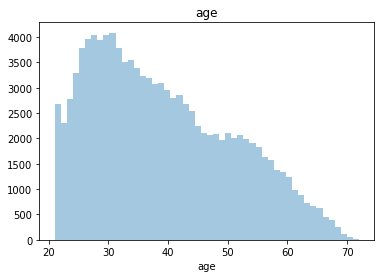

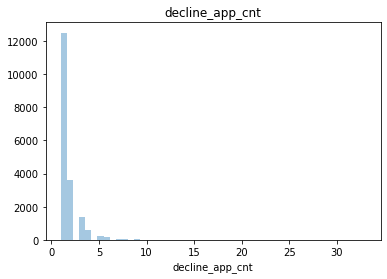

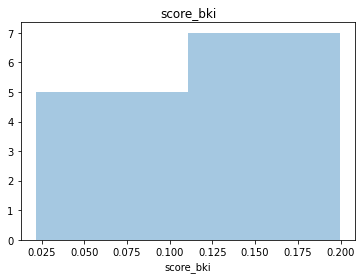

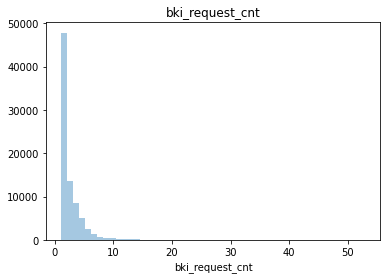

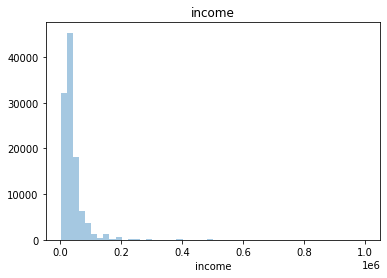

In [1979]:
# Построим графики распределения  переменных.
for i in num_cols:
    plt.figure()
    sns.distplot(df[i][df[i] > 0].dropna(), kde = False, rug=False)
    plt.title(i)
    plt.show()

In [1980]:
# df['income'].hist()

После построения гистограмм стало очевидно, что распределения всех числовых переменных имеют сдвиг влево
 

визуально нет нормального распределения.

 Т.е. данные, далеко отстающие от среднего значения, могут искажать уравнение регрессии. Наша задача минимизировать влияние таких данных. Желательно не исключая их.

##### поиск выбросов в числовых переменных

In [1981]:
for col in num_cols:
    vybros(col)
    

Количество выбросов в признаке 'age': 0.
25-й процентиль: 30.0, 75-й процентиль: 48.0, IQR: 18.0, Границы выбросов: [3.0, 75.0]
В признаке 'decline_app_cnt' есть значения, которые могут считаться выбросами
Количество выбросов в признаке 'decline_app_cnt': 18677.
25-й процентиль: 0.0, 75-й процентиль: 0.0, IQR: 0.0, Границы выбросов: [0.0, 0.0]
В признаке 'score_bki' есть значения, которые могут считаться выбросами
Количество выбросов в признаке 'score_bki': 518.
25-й процентиль: -2.2604336700000003, 75-й процентиль: -1.5678881525, IQR: 0.6925455175000004, Границы выбросов: [-3.299251946250001, -0.5290698762499992]
В признаке 'bki_request_cnt' есть значения, которые могут считаться выбросами
Количество выбросов в признаке 'bki_request_cnt': 2636.
25-й процентиль: 0.0, 75-й процентиль: 3.0, IQR: 3.0, Границы выбросов: [-4.5, 7.5]
В признаке 'income' есть значения, которые могут считаться выбросами
Количество выбросов в признаке 'income': 7000.
25-й процентиль: 20000.0, 75-й процентиль: 4

#####Построим boxplot’ы для численных переменных



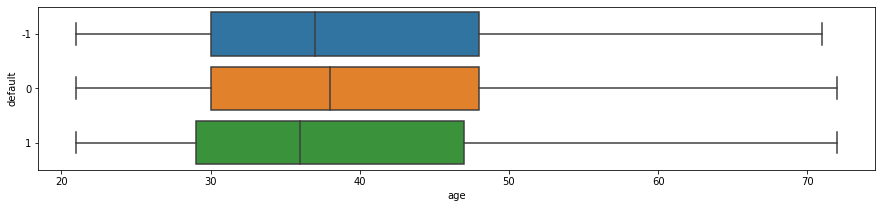

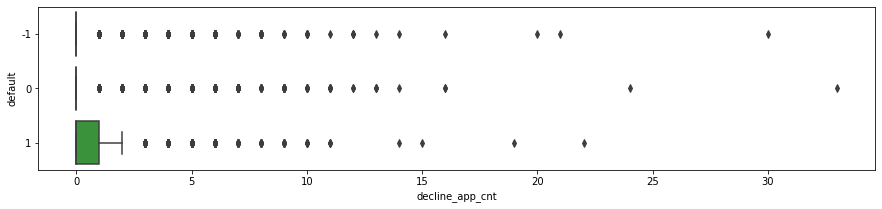

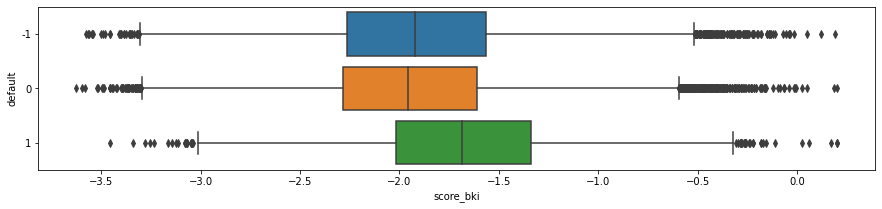

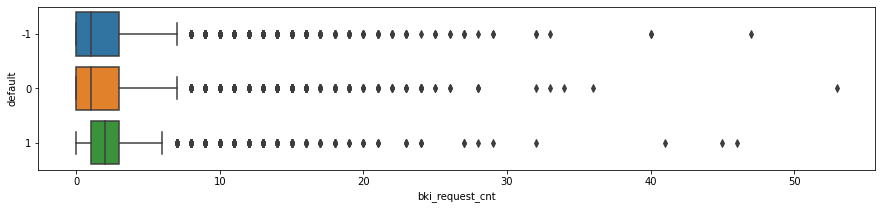

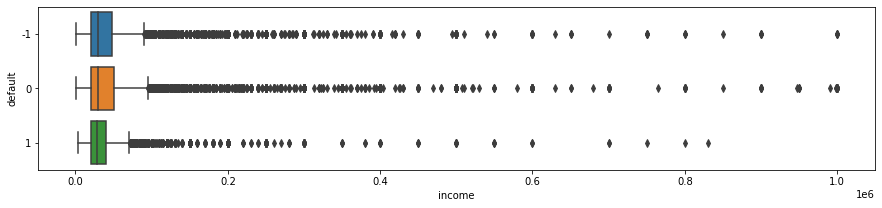

In [1982]:
# Графики перед возможным логарифмированием
for col in num_cols:
    plt.figure(figsize=(15,3))
    sns.boxplot(y = df['default'], x = df[col], orient='h')

сделаем логарифмирование признаков и посмотрим на графиках их распределение

###### AGE (возраст)

In [1983]:
df['age'][df['default']==1].mean()

38.52539479300043

In [1984]:
df['age'][df['default']==0].mean()

39.3905039812501

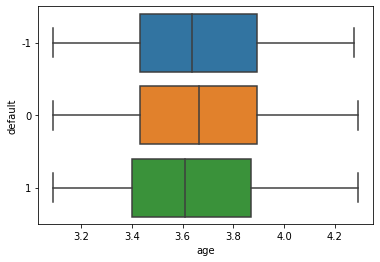

In [1985]:
# логарифмируем возвраст
df['age'] = np.log(df['age'] + 1)
# строим boxplot для логарифм age
sns.boxplot(y = df['default'], x = df['age'], orient='h')
#sns.boxplot(y='age', x='default', data=train_df)	# дефолтные клиенты и возраст

▶дефолтные клиенты в среднем младше.

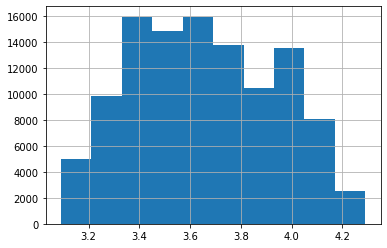

In [1986]:
# строим график после логарифмирования
df['age'].hist()

In [1987]:
# Распределение логнормальное, в модель пойдет логарифм от признака

###### decline_app_cnt   (количество отмененных заявок)

In [1988]:
df['decline_app_cnt'][df['default']==0].mean()

0.2408772719512006

In [1989]:
df['decline_app_cnt'][df['default']==1].mean()

0.5154716175842936

In [1990]:
# количество отмененных заявок равное 33 , кажется выбросом. попробуем удалить его
#train_df = train_df.loc[train_df['decline_app_cnt'] > 33]

In [1991]:
# Ограничим выбросы в отказах до 10, не будем удалять все.
df['decline_app_cnt'] = df['decline_app_cnt'].apply(lambda x: 10 if x  >=  10 else x)
# Создадим бинарную переменную, беря во внимание, что большое количество клиентов вообще не имеет отказов
df['decline_app_bin'] = df['decline_app_cnt'].apply(lambda x: 1 if x  >=  1 else 0)

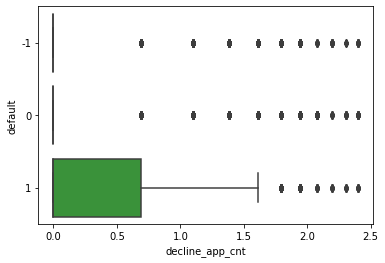

In [1992]:
# логарифмируем количество отказов прошлых заявок
df['decline_app_cnt'] = np.log(df['decline_app_cnt']+1)
# строим boxplot для логарифм decline_app_cnt
sns.boxplot(y = df['default'], x = df['decline_app_cnt'], orient='h')
#sns.boxplot(y='decline_app_cnt', x='default', data=df) # дефолтные клиенты и количество омененных заявок

In [1993]:
df['decline_app_cnt'][df['default']==0].mean()

0.13520801565405763

In [1994]:
df['decline_app_cnt'][df['default']==1].mean()

0.27024065136932945

▶дефолтные клиенты в среднем имеют большее количество отмененных заявок

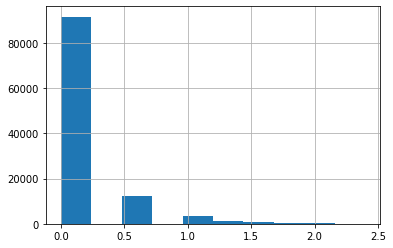

In [1995]:
# строим график после логарифмирования
df['decline_app_cnt'].hist()
# Распределение логнормальное, в модель пойдет логарифм от признака

######bki_request_cnt  (запросы в БКИ)

In [1996]:
df['bki_request_cnt'][df['default']==1].mean()

2.4623346137430646

In [1997]:
df['bki_request_cnt'][df['default']==0].mean()

1.9331336241016965

In [1998]:
# Ограничим выбросы в bki_request_cnt до 10
df['bki_request_cnt'] = df['bki_request_cnt'].apply(lambda x: 10 if x  >=  10 else x)
# Создадим бинарную переменную, беря во внимание, что большое количество клиентов вообще не имеет отказов
df['bki_request_cnt_bin'] = df['bki_request_cnt'].apply(lambda x: 1 if x  >=  1 else 0)

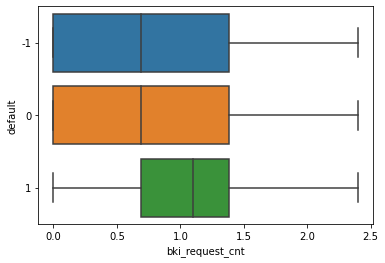

In [1999]:
# логарифмируем количество запросов в БКИ
df['bki_request_cnt'] = np.log(df['bki_request_cnt'] + 1)
# дефолтные клиенты и запросы в БКИ (логорифмиров)
#sns.boxplot(y='bki_request_cnt', x='default', data=df)
sns.boxplot(y = df['default'], x = df['bki_request_cnt'], orient='h')

In [2000]:
df['bki_request_cnt'][df['default']==0].mean()

0.855964845700914

In [2001]:
df['bki_request_cnt'][df['default']==1].mean()

1.0071038543881987

▶дефолтные клиенты имеют больше запросов в БКИ

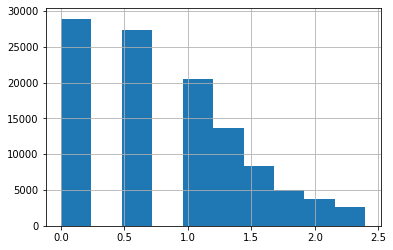

In [2002]:
# строим график после логарифмирования
df['bki_request_cnt'].hist()

# Распределение логнормальное, в модель пойдет логарифм от признака

###### income  (доход клиента)

In [2003]:
df['income'][df['default']==0].mean()

41799.713287907245

In [2004]:
df['income'][df['default']==1].mean()

36288.1133162612

In [2005]:
# Создадим бинарный признак для доходов менее 25000 и более
df['income_bin'] = df['income'].apply(lambda x: 1 if x  < 25000  else 0)
# Ограничим выбросы 


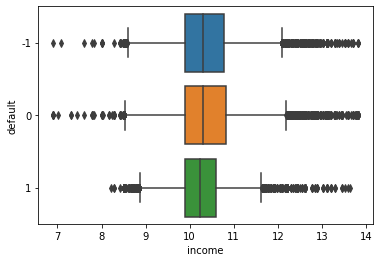

In [2006]:
# логарифмируем доход income
df['income']=np.log(df['income']+1)
#sns.boxplot(y='income', x='default', data=df) # дефолтные клиенты по отношению дохода клиентов(прологорифм)
sns.boxplot(y = df['default'], x = df['income'], orient='h')

In [2007]:
df['income'][df['default']==0].mean()

10.36022085007154

In [2008]:
df['income'][df['default']==1].mean()

10.247338977047745

▶дефолтные клиенты в среднем имеют ниже доход

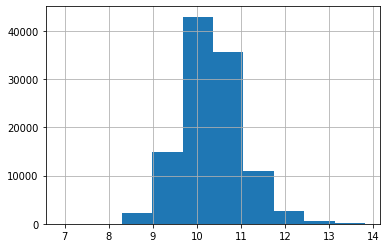

In [2009]:
# строим график после логарифмирования
df['income'].hist()

# Распределение логнормальное, в модель пойдет логарифм от признака

###### score_bki

In [2010]:
df['score_bki'][df['default']==0].mean()

-1.938048147053856

In [2011]:
df['score_bki'][df['default']==1].mean()

-1.675637110018135

In [2012]:
# Ограничим выбросы 
df['score_bki'] = df['score_bki'].apply(lambda x: -4 if x  <= -4  else x)
df['score_bki'] = df['score_bki'].apply(lambda x: 1 if x  >= 1 else x)

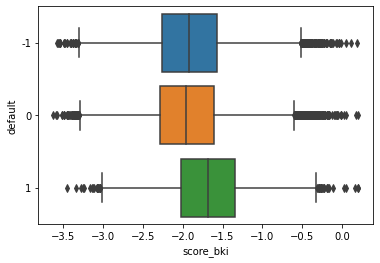

In [2013]:
# логарифмируем доход income
#df['score_bki']=np.log(df['score_bki']+1)
# дефолтные клиенты по отношению дохода клиентов(прологорифм)
sns.boxplot(y = df['default'], x = df['score_bki'], orient='h')


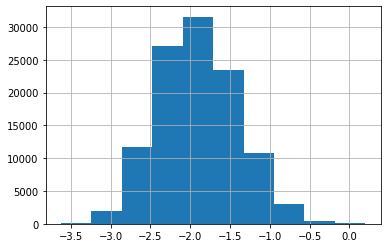

In [2014]:
# строим график после логарифмирования
df['score_bki'].hist()

Резюме по численным признакам:

После построения гистограмм стало очевидно, что распределения почти всех числовых переменных имеют тяжёлый правый хвост. 

**age**: Распределение логнормальное, выбросов по квартилям нет. Признак будем использовать, как есть.

**decline_app_cnt**: Распределение логнормальное, выбросов очень много. Возьмём логарифм, чтобы избежать чувствительности к сильным отклонениям. Выбросы удалять пока не будем. Возможно это потребуется для улучшения модели.

**score_bki**: Распределение логнормальное. Выбросы есть,но удалять не будем.

**bki_request_cnt**: Распределение логнормальное, выбросов не много, удалять не будем. Возьмём логарифм, чтобы сделать распределение более нормальным.

**income**: Распределение логнормальное, выбросов очень много, удалять их пока не будем. Возьмём логарифм. К вопросу об удалении выбросов вернемся после построения модели при необходимости.

##### оценка значимости численных признаков

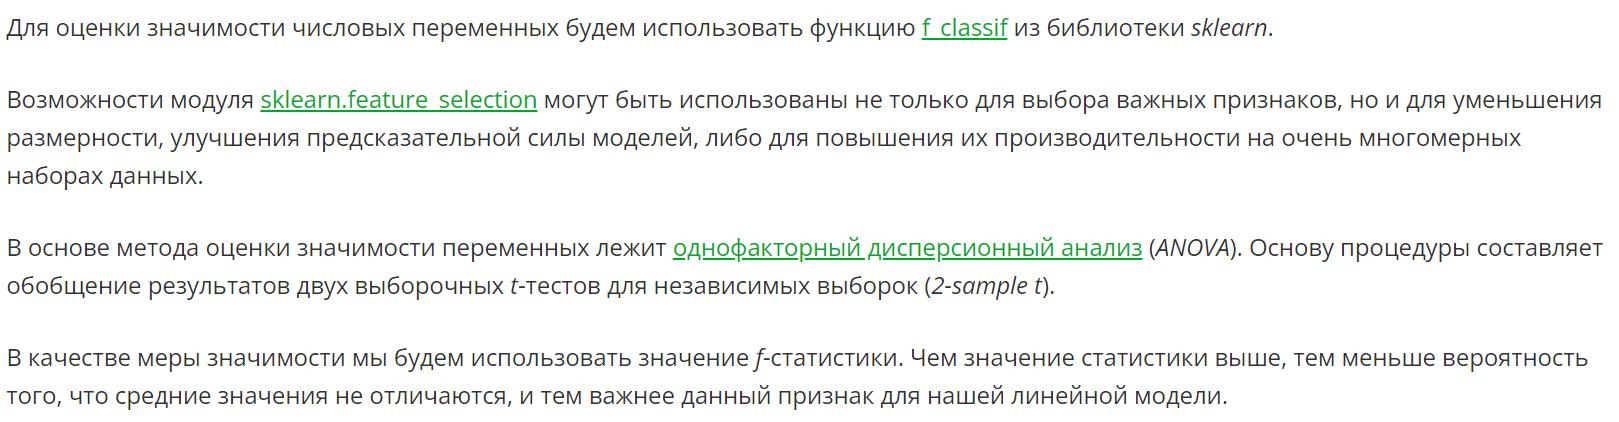

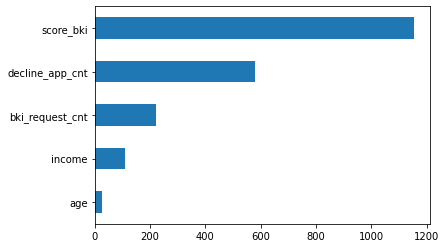

In [2015]:
imp_num = pd.Series(f_classif(df[num_cols], df['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

In [2016]:
# самый значимый из числовых признаков у нас получается признак score_bki

In [2017]:
df[num_cols].corr()

,age,decline_app_cnt,score_bki,bki_request_cnt,income
age,1.000000,-0.128708,-0.109169,0.050084,-0.090734
decline_app_cnt,-0.128708,1.000000,0.207366,0.122693,-0.014124
score_bki,-0.109169,0.207366,1.000000,0.138810,0.002592
bki_request_cnt,0.050084,0.122693,0.138810,1.000000,0.076374
income,-0.090734,-0.014124,0.002592,0.076374,1.000000


##### времянной *ряд*

In [2018]:
df['app_date'] = pd.to_datetime(df['app_date'], format='%d%b%Y')
df.head(3)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,work_address,income,sna,first_time,foreign_passport,sample,default,decline_app_bin,bki_request_cnt_bin,income_bin
0,74835,2014-03-22,GRD,M,3.401197,Y,Y,0.000000,0,-2.271884,...,2,10.819798,1,4,N,0,-1,0,1,0
1,17527,2014-01-24,SCH,F,3.688879,N,N,1.791759,0,-1.504999,...,2,8.517393,4,3,N,0,-1,1,1,1
2,75683,2014-03-23,UGR,M,3.931826,Y,Y,0.000000,0,-1.691339,...,2,10.308986,1,3,Y,0,-1,0,1,0


In [2019]:
# проверим начало и конец периода нашего датасета 
start = df.app_date.min()
end = df.app_date.max()
start, end

(Timestamp('2014-01-01 00:00:00'), Timestamp('2014-04-30 00:00:00'))

в датасете представлен период с 1 января по 30 апреля 2014 года. Можно создать дополнительный численный признак, отражающий количество дней от старта датасета до конкретной записи. Это необходимо сделать, т.к. собственно сам временной ряд необходимо будет позже исключить из датасета перед построением модели.

In [2020]:
df['app_date_delta'] = (df['app_date'] - start).dt.days
# преобразуем в целый тип
df['app_date_delta'] = df['app_date_delta'].convert_dtypes('int')

In [2021]:
df.head(3)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,income,sna,first_time,foreign_passport,sample,default,decline_app_bin,bki_request_cnt_bin,income_bin,app_date_delta
0,74835,2014-03-22,GRD,M,3.401197,Y,Y,0.000000,0,-2.271884,...,10.819798,1,4,N,0,-1,0,1,0,80
1,17527,2014-01-24,SCH,F,3.688879,N,N,1.791759,0,-1.504999,...,8.517393,4,3,N,0,-1,1,1,1,23
2,75683,2014-03-23,UGR,M,3.931826,Y,Y,0.000000,0,-1.691339,...,10.308986,1,3,Y,0,-1,0,1,0,81


In [2022]:
# добавление нового признака в список числовых признаков
num_cols.append('app_date_delta')
#time_cols_int=['app_date_delt']
# удаление временного ряда из датасета
df.drop(['app_date'], axis=1, inplace=True)

In [2023]:
# проверим количество дефолтов в течение срока, отражённого в представленном датасете
data_temp = df.loc[df['sample'] == 1] 
data_temp[['default'] + ['app_date_delta']].groupby('app_date_delta').sum()

,default
app_date_delta,
0,6
1,18
2,24
3,51
4,33
...,...
115,42
116,41
117,53


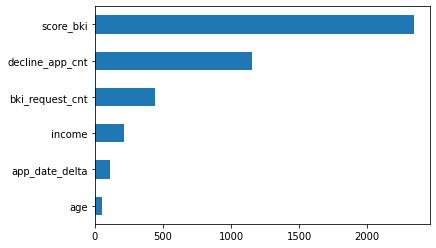

In [2024]:
imp_num = pd.Series(f_classif(data_temp[num_cols], data_temp['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')


##**Категориальные и бинарные признаки.**
чтобы алгоритмы машинного обучения могли работать с категориальными данными, их нужно преобразовать в числа.

##### бинарные признаки

In [2025]:
#Обновим bin переменые
# убедимся, что признаки sex, сar, car_type, good_work, foreign_passport,'decline_app_bin','income_bin' являются бинарными
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport','decline_app_bin','income_bin','bki_request_cnt_bin']
for col in bin_cols:
    print(f'Признак {col} принимает следующие значния:')
    display(df[col].value_counts())

Признак sex принимает следующие значния:


F    61836
M    48312
Name: sex, dtype: int64

Признак car принимает следующие значния:


N    74290
Y    35858
Name: car, dtype: int64

Признак car_type принимает следующие значния:


N    89140
Y    21008
Name: car_type, dtype: int64

Признак good_work принимает следующие значния:


0    91917
1    18231
Name: good_work, dtype: int64

Признак foreign_passport принимает следующие значния:


N    93721
Y    16427
Name: foreign_passport, dtype: int64

Признак decline_app_bin принимает следующие значния:


0    91471
1    18677
Name: decline_app_bin, dtype: int64

Признак income_bin принимает следующие значния:


0    73682
1    36466
Name: income_bin, dtype: int64

Признак bki_request_cnt_bin принимает следующие значния:


1    81240
0    28908
Name: bki_request_cnt_bin, dtype: int64

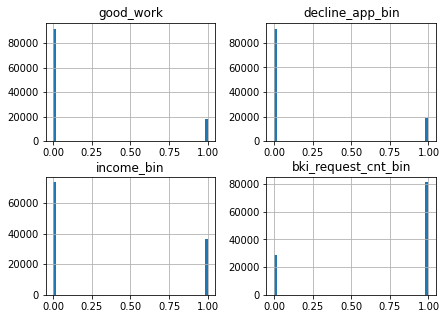

In [2026]:
df[bin_cols].hist(bins=50, figsize=(7,5))
plt.show()

###### sex (пол) 0-жинщины, 1-мужчины

Text(0.5, 1.0, 'Диаграма признака sex в датасете, %')

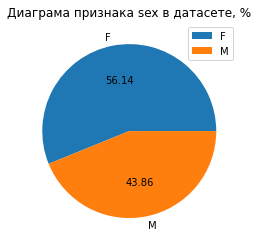

In [2027]:
df['sex'].value_counts().plot(kind='pie', label='', autopct="%.2f")
plt.legend()
plt.title('Диаграма признака sex в датасете, %')

In [2028]:
# видно, что клиентов женщин больше

###### Автомобиль (car)  0-нет машины, 1-есть машина

Text(0.5, 1.0, 'Диаграма признака car в датасете, %')

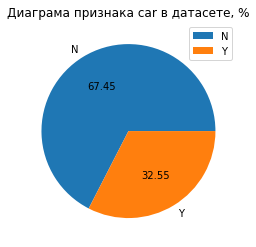

In [2029]:
df['car'].value_counts().plot(kind='pie', label='', autopct="%.2f")
plt.legend()
plt.title('Диаграма признака car в датасете, %')

In [2030]:
# видно, что клиентов без машины больше

###### car_type  (Автомобиль)    0 - нет иномарки, 1 - есть иномарка

Text(0.5, 1.0, 'Диаграма признака car_type в датасете, %')

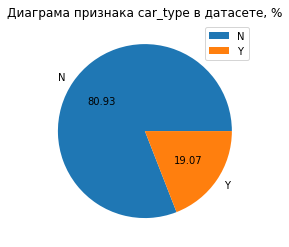

In [2031]:
df['car_type'].value_counts().plot(kind='pie', label='', autopct="%.2f")
plt.legend()
plt.title('Диаграма признака car_type в датасете, %')

In [2032]:
# из клиентов иномарками владеют только  около 19%

###### good_work  наличие "хорошей" работы

Text(0.5, 1.0, 'Диаграма признака good_work в датасете, %')

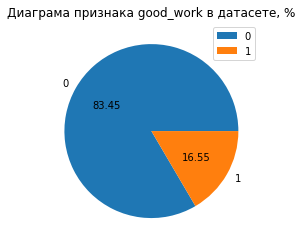

In [2033]:
df['good_work'].value_counts().plot(kind='pie', label='', autopct="%.2f")
plt.legend()
plt.title('Диаграма признака good_work в датасете, %')

In [2034]:
# примерно 16.5% имеют "хорошую" работу

######foreign_passport наличие загран.паспорта

Text(0.5, 1.0, 'Диаграма признака foreign_passport в датасете, %')

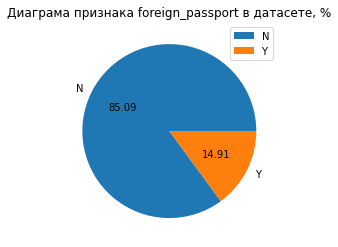

In [2035]:
df['foreign_passport'].value_counts().plot(kind='pie', label='', autopct="%.2f")
plt.legend()
plt.title('Диаграма признака foreign_passport в датасете, %')

In [2036]:
# 15% из клиентов имеют загран.паспорт

###### 'decline_app_bin' 

Text(0.5, 1.0, 'Диаграма признака decline_app_bin в датасете, %')

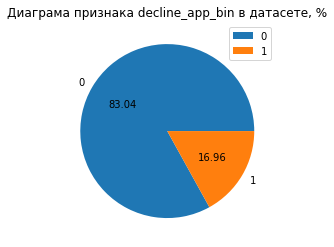

In [2037]:
df['decline_app_bin'].value_counts().plot(kind='pie', label='', autopct="%.2f")
plt.legend()
plt.title('Диаграма признака decline_app_bin в датасете, %')

In [2038]:
# 83% имеют хотя бы один отказ

######bki_request_cnt_bin

Text(0.5, 1.0, 'Диаграма признака bki_request_cnt_bin в датасете, %')

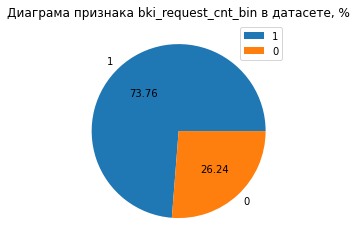

In [2039]:
df['bki_request_cnt_bin'].value_counts().plot(kind='pie', label='', autopct="%.2f")
plt.legend()
plt.title('Диаграма признака bki_request_cnt_bin в датасете, %')

In [2040]:
# 74% имеют хотя бы один запрос в бки

######'income_bin'

Text(0.5, 1.0, 'Диаграма признака income_bin в датасете, %')

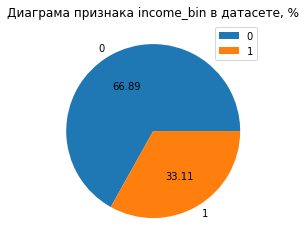

In [2041]:
df['income_bin'].value_counts().plot(kind='pie', label='', autopct="%.2f")
plt.legend()
plt.title('Диаграма признака income_bin в датасете, %')

In [2042]:
# 67% имеют доход больше 25000

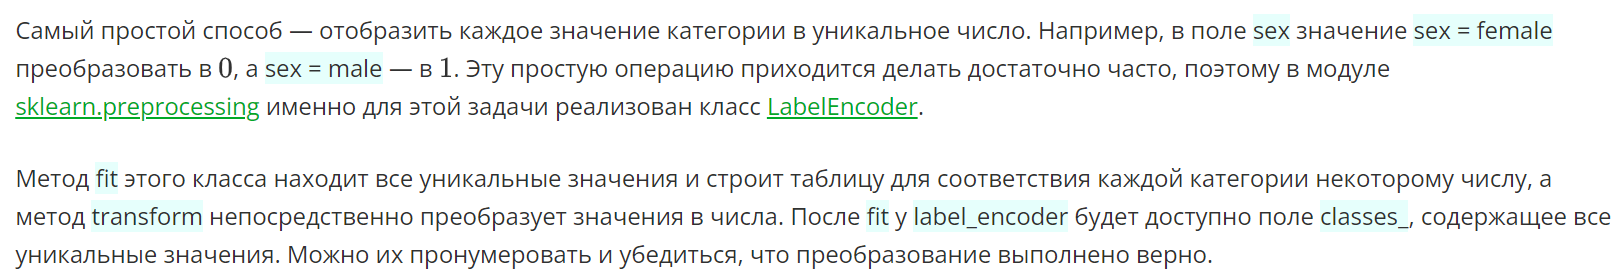

In [2043]:
# Для бинарных признаков мы будем использовать LabelEncoder

label_encoder = LabelEncoder()

for column in bin_cols:
    df[column] = label_encoder.fit_transform(df[column])
    
# убедимся в преобразовании    
df.head(3)

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,...,income,sna,first_time,foreign_passport,sample,default,decline_app_bin,bki_request_cnt_bin,income_bin,app_date_delta
0,74835,GRD,1,3.401197,1,1,0.000000,0,-2.271884,1.386294,...,10.819798,1,4,0,0,-1,0,1,0,80
1,17527,SCH,0,3.688879,0,0,1.791759,0,-1.504999,1.098612,...,8.517393,4,3,0,0,-1,1,1,1,23
2,75683,UGR,1,3.931826,1,1,0.000000,0,-1.691339,0.693147,...,10.308986,1,3,1,0,-1,0,1,0,81


преобразовали бинарные признаки 'sex', 'car', 'car_type', 'good_work', 'foreign_passport', 'decline_app_bin', 'income_bin', bki_request_cnt_bin
 в вид 1 и 0.

##### значимость бинарных признаков

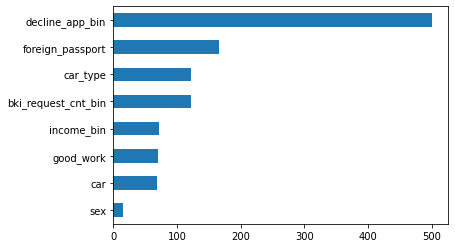

In [2044]:
# Посмотрим на значимость бинарных переменных в обучаемой выборке
imp_num = pd.Series(f_classif(df[bin_cols], df['default'])[0], index = bin_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

Самое сильное влияние оказывает отсутствие или наличие отказа в кредите в прошлом. еще влияет наличие загранпаспорта, а также типа машины и подавал заявку в бки или нет. самое маленькое влияние имеет пол кредитора.

In [2045]:
df[bin_cols].corr()

,sex,car,car_type,good_work,foreign_passport,decline_app_bin,income_bin,bki_request_cnt_bin
sex,1.000000,0.277470,0.224822,-0.044026,0.085924,0.021847,-0.283978,-0.032048
car,0.277470,1.000000,0.698760,0.001565,0.106893,-0.039715,-0.238475,-0.045058
car_type,0.224822,0.698760,1.000000,0.016160,0.145373,-0.050693,-0.249697,-0.033117
good_work,-0.044026,0.001565,0.016160,1.000000,0.048491,-0.036475,-0.047114,0.002702
foreign_passport,0.085924,0.106893,0.145373,0.048491,1.000000,-0.028485,-0.182421,-0.018408
decline_app_bin,0.021847,-0.039715,-0.050693,-0.036475,-0.028485,1.000000,-0.004693,0.059594
income_bin,-0.283978,-0.238475,-0.249697,-0.047114,-0.182421,-0.004693,1.000000,-0.022039
bki_request_cnt_bin,-0.032048,-0.045058,-0.033117,0.002702,-0.018408,0.059594,-0.022039,1.000000


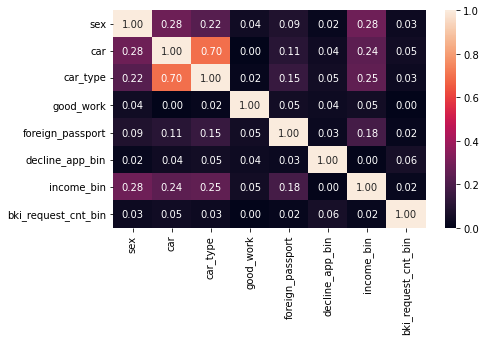

In [2046]:
plt.figure(figsize=(7, 4))
sns.heatmap(df[bin_cols].corr().abs(), vmin=0, vmax=1, annot=True, fmt='.2f')

##### Тринарные признаки: домашний и рабочий адресс.


In [2047]:

# можно выделить Тринарные признаки т.е. в нашем датасете это домашний и рабочий адресс.

trin_cols=df.columns[df.apply(pd.Series.nunique).values==3]
trins=df[trin_cols]

попробуем рассмотреть их в качестве порядковой шкалы (предполагая наличие какой-то связи номера и верояности дефолта, к примеру номер зоны характеризующей расстояние от центра города и т. п.), а также подвергнуть векторизации чтобы понять насколько тесно они сами по себе (абстрагируясь от присвоенного кода) коррелируют с регрессиией.

 попытаемся понять, несёт ли какую-то смысловую нагрузку кодификация адресов работы и проживания.

##### education образование

В ходе предварительного анализа данных было выявлено наличие пропусков только в одном признаке - education. Устраним эти пропуски, заполним значением IDK (неизвестно).
пусть категории в данном признаке имеют следующие значение:

* SCH (школа)
* GRD (бакалавр)
* UGR (кандидат в бакалавры)
* PGR (магистр)
* ACD (академик)

In [2048]:
pd.concat([df.education.value_counts(dropna=False), df.education.value_counts(dropna=False, normalize=True).round(4)*100], axis=1)

,education,education
SCH,57998,52.65
GRD,34768,31.56
UGR,14748,13.39
PGR,1865,1.69
NaN,478,0.43
ACD,291,0.26


Вклад наблюдений с отсутствующим образованием незначителен (0,41%), и в принципе мы могли бы удалить эти данные. Но с другой стороны датасет вполне однородный и эти наблюдения можно оставить или заменить.
* проверим одну гипотезу о том что люди с одинаковым образованием в среднем будут в одних и тех же группах

In [2049]:
# заменю пропуски на IDK чтоб рассмотреть распределение и проверить гипотезу 
df.education.fillna('IDK', inplace=True)

SCH    57998
GRD    34768
UGR    14748
PGR     1865
IDK      478
ACD      291
Name: education, dtype: int64

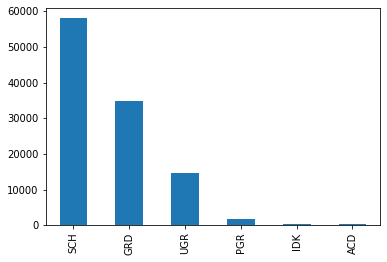

In [2050]:
# 
display(df.education.value_counts())
df.education.value_counts().plot(kind="bar")
plt.show()

Очевидно, что пропущенные значения (отмечены IDK) распределены почти аналогично с клиентами, имеющими только базовое образование. Преобразовать признак "education" в числовой формат можно с помощью LabelEncoder, но тогда будет потерян вес образования, который, возможно, имеет влияние на целевую переменную. Поэтому, предлагается провести преобразование с помощью словаря, назначив "веса" различным типам образования.

In [2051]:
df.education =df.education.replace({'IDK': 0, 'SCH': 1, 'UGR': 2, 'GRD': 3, 'PGR': 4, 'ACD': 5})

In [2052]:
#pd.concat([train_df.education.value_counts(dropna=False), train_df.education.value_counts(dropna=False, normalize=True).round(4)*100], axis=1)

In [2053]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=0).fit(df.drop(['education'],axis=1))
# кластеризация данных. с целью проверки гипотезы, о том что люди с одинаковым образованием в среднем будут в одних и тех же группах

In [2054]:
df['labels']=kmeans.labels_

In [2055]:
df.head(3)

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,...,sna,first_time,foreign_passport,sample,default,decline_app_bin,bki_request_cnt_bin,income_bin,app_date_delta,labels
0,74835,3,1,3.401197,1,1,0.000000,0,-2.271884,1.386294,...,1,4,0,0,-1,0,1,0,80,4
1,17527,1,0,3.688879,0,0,1.791759,0,-1.504999,1.098612,...,4,3,0,0,-1,1,1,1,23,2
2,75683,2,1,3.931826,1,1,0.000000,0,-1.691339,0.693147,...,1,3,1,0,-1,0,1,0,81,4


In [2056]:
df.groupby(['education','labels']).count()['car']
# видим что наша гипотеза не правдоподобна, люди со схожим образованием имеют разные наборы признаков.

education  labels
0          0           120
           1            65
           2            97
           3            97
           4            99
1          0         11941
           1         10614
           2         12193
           3         11577
           4         11673
2          0          2799
           1          3357
           2          2586
           3          3042
           4          2964
3          0          6649
           1          7684
           2          6627
           3          6871
           4          6937
4          0           382
           1           398
           2           397
           3           336
           4           352
5          0            56
           1            63
           2            65
           3            53
           4            54
Name: car, dtype: int64

так как наша гипотеза показала свое неправдоподобие, надо бы удалить пропущенные значения, но в этот раз хочу заменить их на моду

In [2057]:
# просто удалим пропущенные значения!!!!!!!!!!!!!!
#train_df=train_df.loc[train_df['education']!=0]

In [2058]:
# Считаем моду
mode_education  = df['education'].mode()[0]
# Заменим пропуски на моду
df['education'] = df['education'].apply(lambda x: mode_education if x == 0 else x)

#####Посмотрим на значимость категориальных переменных

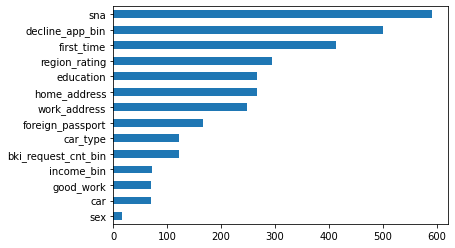

In [2059]:
# Посмотрим на значимость категориальных переменных
imp_cat = pd.Series(f_classif(df[bin_cols + cat_cols], df['default'])[0], index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')


Резюме по оценке значимости категориальных и бинарных переменных:
Самым значимым признаком является связь заемщика с клиентами банка (sna).
Далее, наличие отмененных заявок в прошлом (decline_app_bin). 
Давность наличия информации о заемщике (first_time), а затем, практически с одинаковым значением, идет рейтинг региона (region_rating), категоризатор домашнего адреса (home_address), уровень образования клиента (education) и категоризатор рабочего адреса (work_address)

Пол заемщика имеет самое малое значение. 

###Оценка значимости переменных

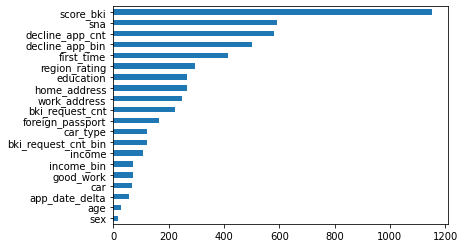

In [2060]:
# Посмотрим на значимость всех переменных
imp_num = pd.Series(f_classif(df[cat_cols + num_cols + bin_cols], 
                              df['default'])[0], index = cat_cols + num_cols + bin_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

**Резюме по оценке значимости переменных:**
* самым значимыми признаками являются score_bki скоринговый балл по данным из БКИ
* еще более значимы признаки sna, кол-во отменненых заявок в прошлом и бинарный этот признак, first_time
* region_rating, образование, домашний адрес, уровень образования, рабочий адресс, количество запросов в бки
* наличие загран.паспорта, тип автомобиля, зароботок.

самым мало значимым является признок пол клиента.

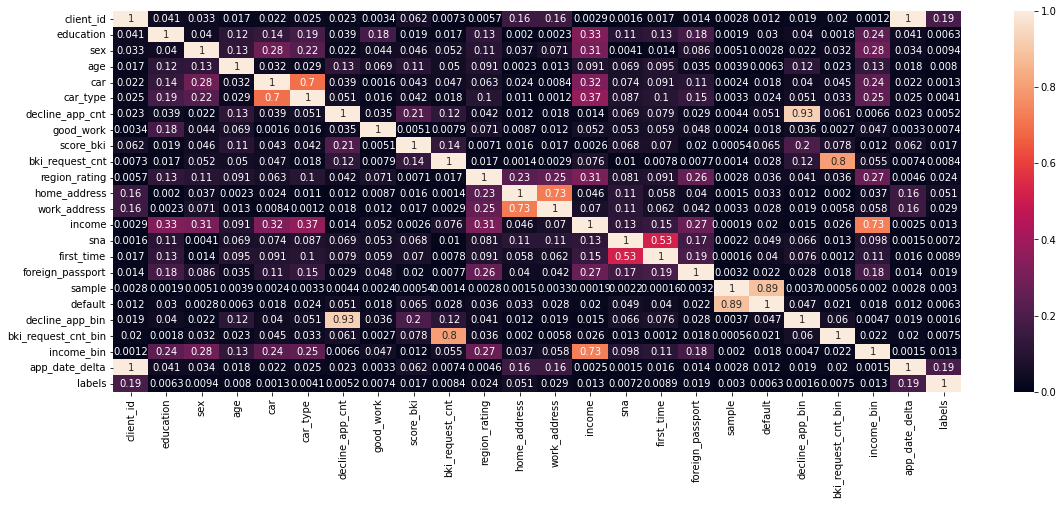

In [2061]:
# Изучим взаимосвязи к признаков
fig, ax = plt.subplots(figsize=(19,7))
sns.heatmap(df.corr().abs(), vmin=0, vmax=1, annot=True)


* корреляция наблюдается между рабочим и домашним адресами (0.73); 
* наличием автомобиля и его типом (0.70); 
* Логично что очень сильная корреляция у нас между заработком и преобразованным в бинарный признак заработок (0.73),
* аналогично количество отклоненных заявок в прошлом и бинарный признак этих заявок (0.93), 
* так же количество запросов в БКИ и бинарный признак количества заявок в БКИ (0.8). 


##Подготовка данных к машинному обучению

Перед обучением регрессии нам следует стандартизировать числовые признаки, а также воспользоваться dummy-кодированием для категориальных переменных, то есть создать отдельную бинарную переменную для каждой категории.

 при тестировании будет использоваться метрика ROC_AUC, обладающая низкой чувствительностью к балансу классов.

In [2062]:
# Применение dummy-кодированием для категориальных переменных
df = pd.get_dummies(df, prefix=cat_cols, columns=cat_cols)

In [2063]:
# Стандартизация числовых признаков
df[num_cols] = pd.DataFrame(StandardScaler().fit_transform(df[num_cols]), columns = df[num_cols].columns)

In [2064]:
df.sample(2)

,client_id,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,income,...,work_address_2,work_address_3,sna_1,sna_2,sna_3,sna_4,first_time_1,first_time_2,first_time_3,first_time_4
108276,9904,1,-1.258393,0,0,1.502686,0,-0.456679,1.644476,-0.314543,...,1,0,1,0,0,0,0,1,0,0
8205,83573,1,-1.007707,1,1,-0.419349,0,-1.113427,0.342401,0.360115,...,0,1,1,0,0,0,0,0,1,0


In [2065]:
# удалим 'client_id' не несет нам никакой информации полезной для анализа
df=df.drop(['client_id'], axis=1)

##### Выделение тренировочной и тестовой частей датасета

In [2066]:
# поделить датасет на train и test
from sklearn.model_selection import train_test_split
# разделим данные 
train_data = df.query('sample == 1').drop(['sample'], axis=1)
test_data = df.query('sample == 0').drop(['sample'], axis=1)

In [2067]:
y = train_data.default.values            
x = train_data.drop(columns=['default'])

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=RANDOM_SEED)


In [2068]:
model = LogisticRegression(random_state=RANDOM_SEED)

model.fit(X_train, y_train)

y_pred_prob = model.predict_proba(X_test)[:,1]
y_pred = model.predict(X_test)

In [2069]:
# печатаем метрики

print('Accuracy: %.4f' % accuracy_score(y_test, y_pred))
print('Precision: %.4f' % precision_score(y_test, y_pred))
print('Recall: %.4f' % recall_score(y_test, y_pred))
print('F1: %.4f' % f1_score(y_test, y_pred))

Accuracy: 0.8752
Precision: 0.4272
Recall: 0.0241
F1: 0.0456


In [2070]:
# Функция расчета точности, а также составляющих матрицы ошибок
def calc_accuracy(y_test, y_pred):
    P = np.sum(y_test == 1)
    N = np.sum(y_test == 0)
    TP = np.sum((y_test == 1) & (y_pred == 1))
    TN = np.sum((y_test == 0) & (y_pred == 0))
    acc = (TP + TN) / (P + N)
    return acc, TP, TN, P, N

In [2071]:
# Считаем метрики модели
def metrics(y_test, probs, y_pred_test):
    fpr, tpr, threshold = roc_curve(y_test, probs)
    roc_auc = roc_auc_score(y_test, probs)

    plt.figure()
    plt.plot([0, 1], label='Baseline', linestyle='--')
    plt.plot(fpr, tpr, label = 'Regression')
    plt.title('Logistic Regression ROC AUC = %0.5f' % roc_auc)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc = 'lower right')
    plt.show()

    f1_test_n = f1_score(y_test, y_pred_test)
    print('f1 score:=',round(f1_test_n,4))

    precision = precision_score(y_test, y_pred_test)
    recall = recall_score(y_test, y_pred_test)
    print('precision: {:.4f}\nrecall: {:.4f}'.format(precision, recall))

    calc_accuracy(y_test, y_pred_test)
    acc, TP, TN, P, N = calc_accuracy(y_test, y_pred_test)
    print('TP = {}\nTN = {}\nP = {}\nN = {}\nacc = {:.4f}'.format(TP, TN, P, N, acc))
    
    dict_metric = {}
    P = np.sum(y_test==1)
    N = np.sum(y_test==0)
    TP = np.sum((y_test==1)&(y_pred_test==1))
    TN = np.sum((y_test==0)&(y_pred_test==0))
    FP = np.sum((y_test==1)&(y_pred_test==0))
    FN = np.sum((y_test==0)&(y_pred_test==1))

    conf_mat = confusion_matrix(y_test, y_pred_test)
    
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat,display_labels=model.classes_)
    disp.plot()

    dict_metric['Accuracy'] = [accuracy_score(y_test, y_pred_test),'Доля верно определённых']
    dict_metric['Precision'] = [precision_score(y_test, y_pred_test),'Точность определения'] 
    dict_metric['Recall'] = [recall_score(y_test, y_pred_test),'Полнота определения']
    dict_metric['F1-score'] = [f1_score(y_test, y_pred_test),'Гармоническое среднее Precision и Recall']
    dict_metric['ROC_AUC'] = [roc_auc_score(y_test, probs),'Площадь под кривой ошибок'] 
    temp_df = pd.DataFrame.from_dict(dict_metric, orient='index', columns=['Значение', 'Описание'])
    display(temp_df)

    

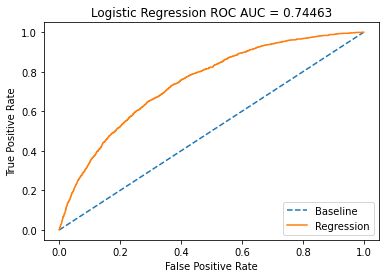

f1 score:= 0.0456
precision: 0.4272
recall: 0.0241
TP = 44
TN = 12874
P = 1827
N = 12933
acc = 0.8752


,Значение,Описание
Accuracy,0.875203,Доля верно определённых
Precision,0.427184,Точность определения
Recall,0.024083,Полнота определения
F1-score,0.045596,Гармоническое среднее Precision и Recall
ROC_AUC,0.744632,Площадь под кривой ошибок


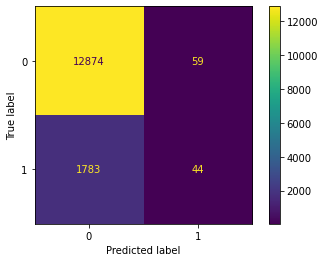

In [2072]:

# Выводим показатели
metrics(y_test, y_pred_prob, y_pred)

Несмотря на относительно высокий показатель ROC_AUC, модель показывает абсолютно неудовлетворительную работу. Об этом свидетельствует очень низкий показатель количества правильных предсказаний от всего класса истинных значений (Recall). Т.о. велика вероятность дефолта по выданным кредитам и прямая потеря банком ресурсов.

###Оптимизируем гиперпоказатели

In [2073]:
# Добавим типы регуляризации
penalty = ['l1', 'l2']

# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 10)

# Создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty)

model = LogisticRegression()
model.fit(X_train, y_train)

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X_train, y_train)
best_C=best_model.best_estimator_.get_params()['C']
# View best hyperparameters
print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

Лучшее Penalty: l2
Лучшее C: 1.0


In [ ]:
# Воспользуемся полученными гиперпоказатями

model2 = LogisticRegression(penalty='l2',C=best_C, max_iter=200)
model2.fit(X_train, y_train)


y_pred_prob = model2.predict_proba(X_test)[:,1]
y_pred = model2.predict(X_test)


# Выводим показатели
metrics(y_test, y_pred_prob, y_pred)

In [ ]:
# печатаем метрики
preds = model2.predict(X_test)
print('Accuracy: %.4f' % accuracy_score(y_test, preds))
print('Precision: %.4f' % precision_score(y_test, preds))
print('Recall: %.4f' % recall_score(y_test, preds))
print('F1: %.4f' % f1_score(y_test, preds))

###Общая модель и тестовые данные для соревнования

In [ ]:
# назначение тренировочной и тестовой части выборки
X_train = train_data.drop(['default'], axis=1)
y_train = train_data.default.values
X_test = test_data.drop(['default'], axis=1)



In [ ]:
X_test.head(3)

In [ ]:
predict_submission = model2.predict_proba(X_test)[:,1]

In [ ]:
submission_end = pd.DataFrame(test_df.client_id)
submission_end['default'] = predict_submission
submission_end.to_csv(path+'/submission_end.csv', index=False)

In [ ]:
#X_cat_test = OneHotEncoder(sparse = False).fit_transform(test_data[cat_cols].values)
#X_num_test = test_data[num_cols].values
#X_bin_test = test_data[bin_cols].values

# Объединяем три типа данных в одну матрицу значений Х
#X_test = np.hstack([X_num_test, X_bin_test, X_cat_test])

# Стандартизируем
#scaler = StandardScaler()
#X_test[:,:len(num_cols)] = scaler.fit_transform(X_test[:,:len(num_cols)]) 

#y_pred_test = model.predict(X_test)
#probs_test = model.predict_proba(X_test)
#probs_test = probs_test[:,1]